Map:   0%|          | 0/16148 [00:00<?, ? examples/s]

Map:   0%|          | 0/4038 [00:00<?, ? examples/s]

Map:   0%|          | 0/16148 [00:00<?, ? examples/s]

Map:   0%|          | 0/4038 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.000000,0.000014,1.000000
2,0.000000,0.000006,1.000000
3,0.000000,0.000005,1.000000


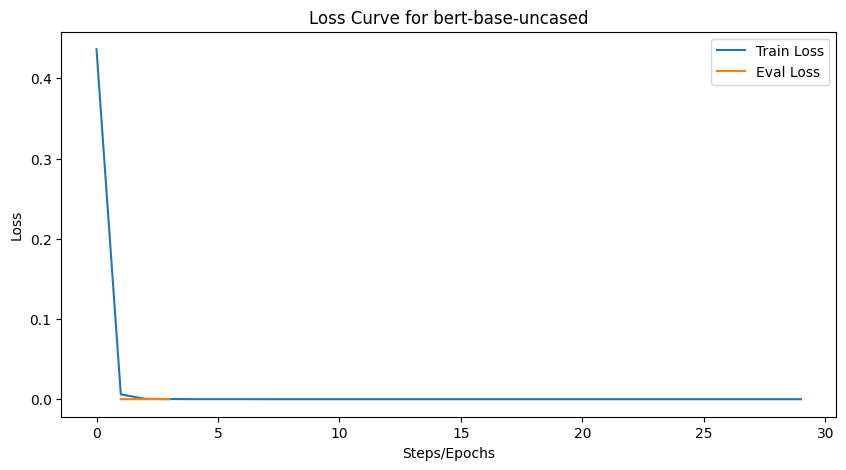

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


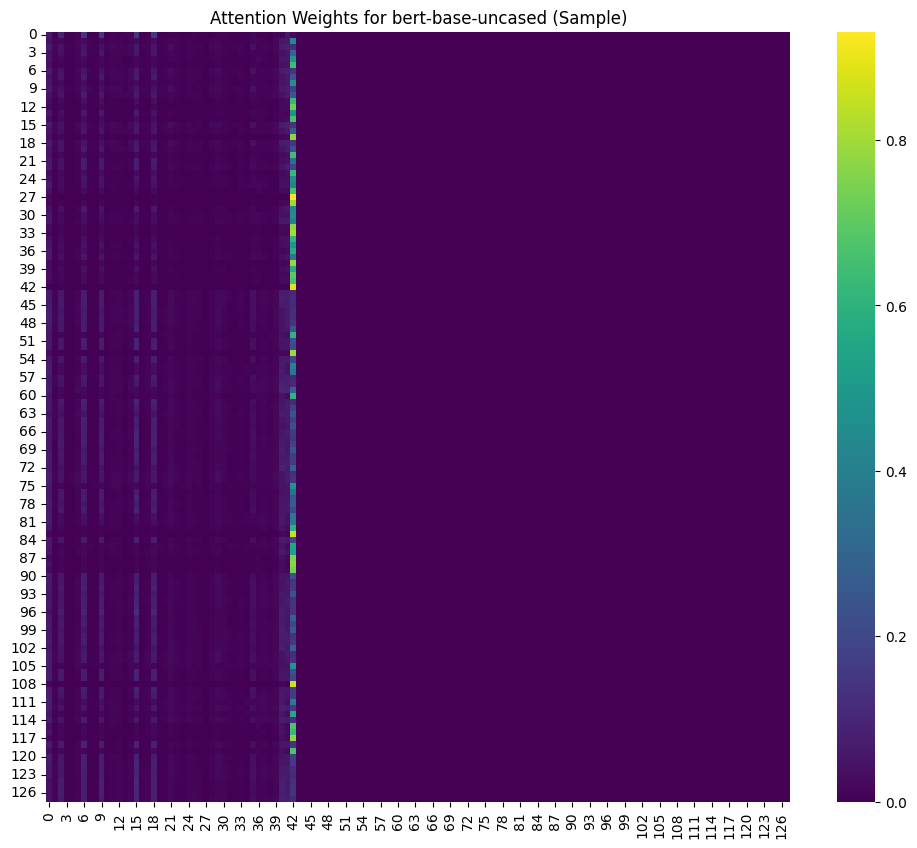

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.000000,0.000009,1.000000
2,0.000000,0.000004,1.000000
3,0.000000,0.000003,1.000000


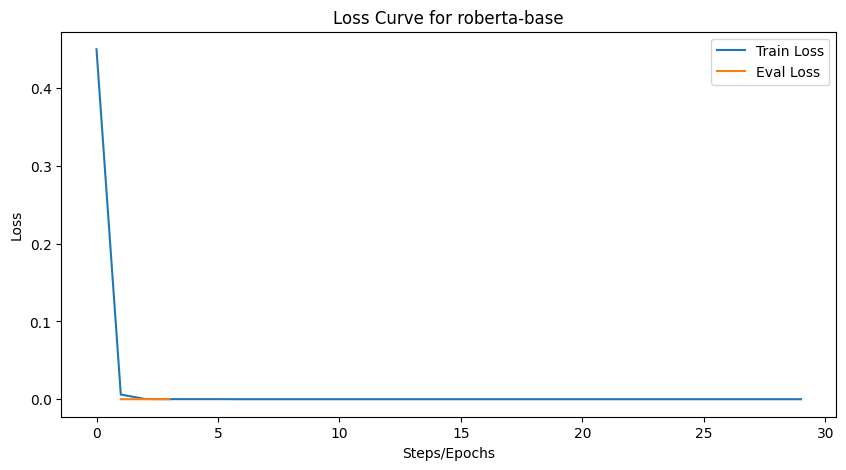

RobertaSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


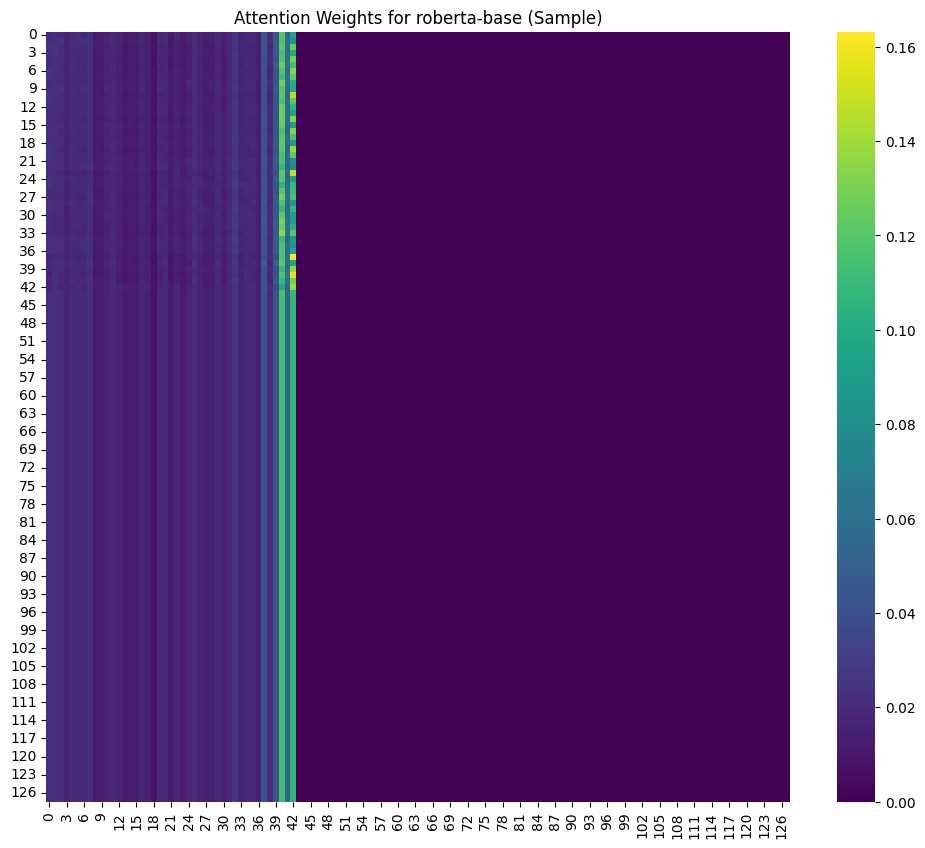

BERT Training Logs (first 5): [{'loss': 0.4363, 'grad_norm': 0.5766221880912781, 'learning_rate': 9.900000000000002e-06, 'epoch': 0.09900990099009901, 'step': 100}, {'loss': 0.006, 'grad_norm': 0.022172657772898674, 'learning_rate': 1.9900000000000003e-05, 'epoch': 0.19801980198019803, 'step': 200}, {'loss': 0.0005, 'grad_norm': 0.007751867175102234, 'learning_rate': 2.9900000000000002e-05, 'epoch': 0.297029702970297, 'step': 300}, {'loss': 0.0002, 'grad_norm': 0.0035831525456160307, 'learning_rate': 3.99e-05, 'epoch': 0.39603960396039606, 'step': 400}, {'loss': 0.0001, 'grad_norm': 0.0018804777646437287, 'learning_rate': 4.99e-05, 'epoch': 0.49504950495049505, 'step': 500}]


In [3]:
# Jobenn Bezuidenhout u22518500
# TRAIN AND FINE-TUNE LLMS
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import evaluate

# Load the combined preprocessed CSV from Phase 2
combined_df = pd.read_csv('Jobenn_preprocessed_NCF_data.csv')  

separator = ' [SEP] '

split_parts = combined_df['text'].apply(
    lambda x: x.split(separator, 1) if separator in x else [x, '']
)

# Convert the list of lists into a DataFrame
split_df = pd.DataFrame(split_parts.tolist(), index=combined_df.index, columns=['pm_text', 'ugr_text'])

# Merge the new columns back into the main DataFrame
combined_df = pd.concat([combined_df, split_df], axis=1)

# Drop the original combined 'text' column, as it's no longer needed
combined_df = combined_df.drop(columns=['text'])

# Map string labels to integers in the DataFrame (0 for 'Benign', 1 for 'Ransomware')
combined_df['label'] = [0 if str(l).lower() == 'benign' else 1 for l in combined_df['label']]

# Split: 80/20 
train_df, test_df = train_test_split(combined_df, test_size=0.2, stratify=combined_df['label'], random_state=42)

# Handle class imbalance: Compute weights 
classes = np.unique(train_df['label'])
class_weights = compute_class_weight('balanced', classes=classes, y=train_df['label'])
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))

## 1. Define the FAST Preprocessing Function 
def preprocess_fast(examples, tokenizer):
    return tokenizer(
        examples['pm_text'],
        examples['ugr_text'],
        truncation=True,
        padding='max_length', 
        max_length=128
    )

columns_to_remove = ['protocol', 'flag', 'family', 'address', 'usd', 'seed_address', 
                     'btc', 'netflow_bytes', 'ip_address', 'clusters', 'threats', 
                     'port', 'time', 'prediction', 'segment', 'embeddings', 
                     'dataset', 'r', 'rw', 'rx', 'rwc', 'rwx', 'rwxc', 'category', 
                     'pm_text', 'ugr_text'] 

# BERT tokenization
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
train_ds_bert = train_dataset.map(
    lambda e: preprocess_fast(e, bert_tokenizer), 
    batched=True, 
    remove_columns=columns_to_remove 
)
test_ds_bert = test_dataset.map(
    lambda e: preprocess_fast(e, bert_tokenizer), 
    batched=True, 
    remove_columns=columns_to_remove 
)

# RoBERTa tokenization
roberta_tokenizer = AutoTokenizer.from_pretrained('roberta-base')
train_ds_roberta = train_dataset.map(
    lambda e: preprocess_fast(e, roberta_tokenizer), 
    batched=True, 
    remove_columns=columns_to_remove 
)
test_ds_roberta = test_dataset.map(
    lambda e: preprocess_fast(e, roberta_tokenizer), 
    batched=True, 
    remove_columns=columns_to_remove 
)


## 3. Define the Simplified Fine-Tune Model Function
def fine_tune_model(model_name, train_ds, test_ds, class_weights):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    
    # Define compute_metrics (Keep as is)
    def compute_metrics(p):
        accuracy = evaluate.load('accuracy')
        preds = np.argmax(p.predictions, axis=1)
        return accuracy.compute(predictions=preds, references=p.label_ids)
    
    training_args = TrainingArguments(
    output_dir=f'./results_{model_name.split("/")[-1]}',
    num_train_epochs=3,
    
    fp16=True,                          
    per_device_train_batch_size=16,     
    per_device_eval_batch_size=16,      
    dataloader_num_workers=4,           
    dataloader_pin_memory=True,         

    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,                  
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
)
    
    # Custom Trainer subclass to override compute_loss
    class CustomTrainer(Trainer):
        def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
            labels = inputs.pop('labels')
            outputs = model(**inputs)
            loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to(outputs.logits.device))
            loss = loss_fct(outputs.logits, labels)
            return (loss, outputs) if return_outputs else loss
    
    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        compute_metrics=compute_metrics,
    )
    
    trainer.train()
    
    # Plot loss
    history = trainer.state.log_history
    train_loss = [log['loss'] for log in history if 'loss' in log]
    eval_loss = [log['eval_loss'] for log in history if 'eval_loss' in log]
    plt.figure(figsize=(10,5))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(range(1, len(eval_loss)+1), eval_loss, label='Eval Loss')
    plt.xlabel('Steps/Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss Curve for {model_name}')
    plt.legend()
    plt.show()
    
    # Extract and plot attention weights (from last layer, first head, for a sample)
    with torch.no_grad():
        sample_text_1 = test_df['pm_text'].iloc[0]
        sample_text_2 = test_df['ugr_text'].iloc[0]
        
        # Tokenizer takes the two parts separately for proper token_type_ids
        sample_input = tokenizer(
            sample_text_1,
            sample_text_2,
            return_tensors='pt', 
            truncation=True, 
            padding='max_length', 
            max_length=128
        )
        
        device = model.device
        sample_input = {k: v.to(device) for k, v in sample_input.items()}
        # -----------------------------------------------------------------------
        
        # The model is already on CUDA, so this call will now succeed
        outputs = model(**sample_input, output_attentions=True)
        
        # Move attention weights back to CPU for NumPy/Matplotlib plotting
        attn = outputs.attentions[-1][0][0].detach().cpu().numpy()  
        
        plt.figure(figsize=(12, 10)) # Increased size for clarity
        sns.heatmap(attn, cmap='viridis')
        plt.title(f'Attention Weights for {model_name} (Sample)')
        plt.show()
    
    return trainer, model, tokenizer

# BERT (uses bert tokenized datasets)
bert_trainer, bert_model, bert_tokenizer = fine_tune_model('bert-base-uncased', train_ds_bert, test_ds_bert, class_weights)

# RoBERTa (uses roberta tokenized datasets)
roberta_trainer, roberta_model, roberta_tokenizer = fine_tune_model('roberta-base', train_ds_roberta, test_ds_roberta, class_weights)

# DeBERTa (uses bert tokenized datasets)
# deberta_trainer, deberta_model, deberta_tokenizer = fine_tune_model('microsoft/deberta-base', train_ds_bert, test_ds_bert, class_weights)

# Training evidence: Print sample logs (full in output)
print("BERT Training Logs (first 5):", bert_trainer.state.log_history[:5])

In [4]:
# INTEGRATE FRAMEWORK 
# Save the fine-tuned models for later use 
bert_model.save_pretrained('bert_finetuned')
bert_tokenizer.save_pretrained('bert_finetuned')  

roberta_model.save_pretrained('roberta_finetuned')
roberta_tokenizer.save_pretrained('roberta_finetuned')

# deberta_model.save_pretrained('deberta_finetuned')
# deberta_tokenizer.save_pretrained('deberta_finetuned')

print("Models and tokenizers saved successfully.")

# Example ensemble integration (using BERT tokenizer for simplicity; adjust if needed)
def predict_ensemble(text):
    inputs = bert_tokenizer(text, return_tensors='pt', truncation=True, max_length=128)
    # Set token_type_ids for the input (assume [SEP] present)
    sep_pos = inputs['input_ids'][0].tolist().index(bert_tokenizer.sep_token_id)
    inputs['token_type_ids'] = torch.tensor([[0] * (sep_pos + 1) + [1] * (128 - sep_pos - 1)])
    
    bert_pred = bert_model(**inputs).logits.argmax(-1).item()
    roberta_pred = roberta_model(**inputs).logits.argmax(-1).item()
    # deberta_pred = deberta_model(**inputs).logits.argmax(-1).item()
    preds = [bert_pred, roberta_pred]
    return max(preds, key=preds.count)  # Majority vote

# Test on sample
sample_text = test_df['text'].iloc[0]
print(f"Ensemble Prediction for '{sample_text[:50]}...': {predict_ensemble(sample_text)} (1=ransomware)")

Models and tokenizers saved successfully.


KeyError: 'text'